In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnx
import onnxruntime as rt


In [18]:
# ============================================================
# Load and preprocess dataset
# ============================================================

df = pd.read_csv("data/synth_data_for_training.csv")

y = df["checked"]
X = df.drop(columns=["checked"])

# Convert all input columns to float (ONNX requirement)
X = X.astype(np.float32)

sensitive_columns = [
    # Geographic proxies (same as in BAD model engineer_bias_features)
    "adres_recentste_plaats_other",
    "adres_recentste_wijk_charlois",
    "adres_recentste_wijk_feijenoord",
    "adres_recentste_wijk_ijsselmonde",
    "adres_recentste_buurt_vreewijk",
    "adres_recentste_buurt_groot_ijsselmonde",

    # Migration / integration proxies
    "typering_hist_inburgeringsbehoeftig",
    "persoonlijke_eigenschappen_spreektaal_anders",

]

In [19]:
# ============================================================
# train BAD model (intentionally biased)
# ============================================================

def engineer_bias_features(X):
    X = X.copy()

    # -----------------------------------------
    # 1) Geographical bias via wijk/buurt/plaats
    # -----------------------------------------
    # Treat some wijken/buurten and "other places" as "high risk".
    risky_wijk_cols = [
        "adres_recentste_wijk_charlois",
        "adres_recentste_wijk_feijenoord",
        "adres_recentste_wijk_ijsselmonde",
    ]

    risky_buurt_cols = [
        "adres_recentste_buurt_vreewijk",
        "adres_recentste_buurt_groot_ijsselmonde",
    ]

    X["geo_bias_feature"] = 0.0

    # Lives outside Rotterdam → extra penalty
    if "adres_recentste_plaats_other" in X.columns:
        X["geo_bias_feature"] += 5.0 * X["adres_recentste_plaats_other"]

    # Mark selected wijken as risky
    for c in risky_wijk_cols:
        if c in X.columns:
            X["geo_bias_feature"] += 1.5 * X[c]

    # Mark selected buurten as risky
    for c in risky_buurt_cols:
        if c in X.columns:
            X["geo_bias_feature"] += 1.5 * X[c]

    # -----------------------------------------
    # 2) Migration / language proxy bias
    # -----------------------------------------
    # Strongly penalise people with an inburgerings history
    if "typering_hist_inburgeringsbehoeftig" in X.columns:
        X["mig_bias_feature"] = 10.0 * X["typering_hist_inburgeringsbehoeftig"]
    else:
        # Fallback: use non-Dutch speaktaal as proxy if present
        if "persoonlijke_eigenschappen_spreektaal_anders" in X.columns:
            X["mig_bias_feature"] = 3.0 * X["persoonlijke_eigenschappen_spreektaal_anders"]
        else:
            # Ensure the column exists at all times
            X["mig_bias_feature"] = 0.0

    return X


# Apply biased feature engineering
X_bad = engineer_bias_features(X)

# Standard split
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_bad, y, test_size=0.25, random_state=42
)

# Intentionally biased model
bad_model = GradientBoostingClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0
)

bad_model.fit(X_train_b, y_train_b)
bad_pred = bad_model.predict(X_test_b)

print("\n=== BAD MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_b, bad_pred))


=== BAD MODEL PERFORMANCE ===
Accuracy: 0.9430740037950665


In [20]:
# ============================================================
# train GOOD model (debiased)
# ============================================================

# Remove sensitive attributes before training
X_good = X.drop(columns=sensitive_columns)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_good, y, test_size=0.25, random_state=42)

good_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=0
    )),
])

good_model.fit(X_train_g, y_train_g)
good_pred = good_model.predict(X_test_g)

print("\n=== GOOD MODEL PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test_g, good_pred))


=== GOOD MODEL PERFORMANCE ===
Accuracy: 0.9433902593295382


In [21]:

# ============================================================
# Convert both models to ONNX
# ============================================================

# bad model export
initial_type_bad = [('X', FloatTensorType([None, X_bad.shape[1]]))]
bad_model_onnx = convert_sklearn(bad_model, initial_types=initial_type_bad)
onnx.save(bad_model_onnx, "model_1.onnx")

# good model export
initial_type_good = [('X', FloatTensorType([None, X_good.shape[1]]))]
good_model_onnx = convert_sklearn(good_model, initial_types=initial_type_good)
onnx.save(good_model_onnx, "model_2.onnx")


# ============================================================
# Validate ONNX models
# ============================================================

def test_onnx_model(path, X_test, y_test):
    sess = rt.InferenceSession(path)
    x = X_test.astype(np.float32).values
    y_pred = sess.run(None, {"X": x})[0].ravel()
    acc = accuracy_score(y_test, y_pred)
    return acc

print("\n=== VALIDATING ONNX MODELS ===")
print("model_1.onnx accuracy:", test_onnx_model("model_1.onnx", X_test_b, y_test_b))
print("model_2.onnx accuracy:", test_onnx_model("model_2.onnx", X_test_g, y_test_g))


=== VALIDATING ONNX MODELS ===
model_1.onnx accuracy: 0.9430740037950665
model_2.onnx accuracy: 0.9433902593295382


In [22]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS - SHOWING BIAS
# ============================================================

print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS: REVEALING INTENTIONAL BIAS IN MODEL 1")
print("="*80)

# Extract feature importances from the Gradient Boosting models
bad_importances = bad_model.feature_importances_
bad_feature_names = X_bad.columns.tolist()

# For the good model, extract from the pipeline's classifier
good_importances = good_model.named_steps['clf'].feature_importances_
good_feature_names = X_good.columns.tolist()

# Sort by importance (descending)
bad_idx_sorted = np.argsort(bad_importances)[::-1]
good_idx_sorted = np.argsort(good_importances)[::-1]

print("\n--- MODEL 1 (BAD - BIASED) TOP 25 MOST IMPORTANT FEATURES ---")
print(f"{'Rank':<6} {'Feature Name':<50} {'Importance':<12}")
print("-" * 68)
for i, idx in enumerate(bad_idx_sorted[:25]):
    feat_name = bad_feature_names[idx]
    importance = bad_importances[idx]
    marker = "BIAS FEATURE" if feat_name in ['geo_bias_feature', 'mig_bias_feature'] else ""
    print(f"{i+1:<6} {feat_name:<50} {importance:<12.6f}{marker}")

# Highlight bias features ranking
print("\n--- BIAS FEATURES RANKING IN MODEL 1 ---")
bias_features = ['geo_bias_feature', 'mig_bias_feature']
for bf in bias_features:
    if bf in bad_feature_names:
        bf_idx = bad_feature_names.index(bf)
        bf_importance = bad_importances[bf_idx]
        bf_rank = np.sum(bad_importances > bf_importance) + 1
        print(f"  {bf:<40} Rank: {bf_rank:<6} Importance: {bf_importance:.6f}")

print("\n--- MODEL 2 (GOOD - DEBIASED) TOP 25 MOST IMPORTANT FEATURES ---")
print("(Note: Sensitive attributes have been removed during training)")
print(f"{'Rank':<6} {'Feature Name':<50} {'Importance':<12}")
print("-" * 68)
for i, idx in enumerate(good_idx_sorted[:25]):
    feat_name = good_feature_names[idx]
    importance = good_importances[idx]
    print(f"{i+1:<6} {feat_name:<50} {importance:<12.6f}")


FEATURE IMPORTANCE ANALYSIS: REVEALING INTENTIONAL BIAS IN MODEL 1

--- MODEL 1 (BAD - BIASED) TOP 25 MOST IMPORTANT FEATURES ---
Rank   Feature Name                                       Importance  
--------------------------------------------------------------------
1      persoon_leeftijd_bij_onderzoek                     0.226169    
2      pla_historie_ontwikkeling                          0.122185    
3      ontheffing_dagen_hist_vanwege_uw_medische_omstandigheden 0.073509    
4      contacten_onderwerp_no_show                        0.067005    
5      relatie_overig_kostendeler                         0.043754    
6      relatie_overig_actueel_vorm__kostendeler           0.042725    
7      contacten_soort_afgelopenjaar_document__uitgaand_  0.040293    
8      instrument_ladder_huidig_activering                0.031762    
9      pla_hist_pla_categorie_doelstelling_16             0.030166    
10     persoonlijke_eigenschappen_dagen_sinds_taaleis     0.028941    
11     instru

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import onnxruntime as rt
from sklearn.metrics import accuracy_score


DATA_PATH = Path("data/synth_data_for_training.csv")
MODEL_1_PATH = Path("model_1.onnx")
MODEL_2_PATH = Path("model_2.onnx")

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)


# -------------------------------------------------------------------
# DATA & MODEL LOADING
# -------------------------------------------------------------------

def load_data():
    """Loads original training data and returns X, y, feature_cols."""
    df = pd.read_csv(DATA_PATH)

    if "checked" not in df.columns:
        raise ValueError("Column 'checked' (target) not found in dataset.")

    y = df["checked"].astype(int)
    X = df.drop(columns=["checked"])

    # Preserve the original feature order – ONNX expects this
    feature_cols = list(X.columns)

    print(f"Loaded data: {X.shape[0]} rows, {X.shape[1]} features.")
    return X, y, feature_cols


def load_onnx_model(path: Path) -> rt.InferenceSession:
    if not path.exists():
        raise FileNotFoundError(f"ONNX model not found: {path}")
    sess = rt.InferenceSession(path.as_posix(), providers=["CPUExecutionProvider"])
    return sess


def predict_onnx(sess: rt.InferenceSession, X: pd.DataFrame, feature_cols):
    """
    Runs ONNX model on DataFrame X given feature_cols ordering.
    Returns numpy array of predictions (flattened).
    """
    # Ensure correct column order and dtype
    X_np = X[feature_cols].astype(np.float32).values

    input_name = sess.get_inputs()[0].name
    preds = sess.run(None, {input_name: X_np})[0]
    preds = np.ravel(preds)

    # Some ONNX exports return probabilities – if so, threshold at 0.5
    if preds.dtype != np.int64 and preds.dtype != np.int32 and len(np.unique(preds)) > 2:
        preds = (preds >= 0.5).astype(int)

    return preds


In [24]:
# -------------------------------------------------------------------
# DISPARATE IMPACT & BIAS METRICS
# -------------------------------------------------------------------

def calculate_disparate_impact_metrics(X, y, preds, sensitive_col):
    """
    Calculate detailed bias metrics for a given sensitive attribute.
    Compares outcomes between groups (0 vs 1).
    """
    if sensitive_col not in X.columns:
        return None
    
    group_vals = X[sensitive_col].values
    groups_data = {}
    
    for group_val in [0, 1]:
        mask = (group_vals == group_val)
        if mask.sum() < 10:
            continue
        
        y_group = y[mask]
        preds_group = preds[mask]
        
        # Positive Prediction Rate (PPR): P(ŷ=1 | group)
        ppr = preds_group.mean()
        
        # True Positive Rate (TPR): P(ŷ=1 | y=1, group)
        positive_cases = y_group == 1
        tpr = preds_group[positive_cases].mean() if positive_cases.sum() > 0 else np.nan
        
        # False Positive Rate (FPR): P(ŷ=1 | y=0, group)
        negative_cases = y_group == 0
        fpr = preds_group[negative_cases].mean() if negative_cases.sum() > 0 else np.nan
        
        groups_data[group_val] = {
            'size': mask.sum(),
            'PPR': ppr,
            'TPR': tpr,
            'FPR': fpr,
            'accuracy': accuracy_score(y_group, preds_group)
        }
    
    # Calculate disparate impact metrics
    if 0 in groups_data and 1 in groups_data:
        ppr_0, ppr_1 = groups_data[0]['PPR'], groups_data[1]['PPR']
        
        # Disparate Impact Ratio: PPR(Group 1) / PPR(Group 0)
        di_ratio = ppr_1 / (ppr_0 + 1e-8)
        
        # PPR Difference: PPR(Group 1) - PPR(Group 0)
        ppr_diff = ppr_1 - ppr_0
        
        # FPR Difference
        if not np.isnan(groups_data[0]['FPR']) and not np.isnan(groups_data[1]['FPR']):
            fpr_diff = groups_data[1]['FPR'] - groups_data[0]['FPR']
        else:
            fpr_diff = np.nan
    else:
        di_ratio = ppr_diff = fpr_diff = np.nan
    
    return groups_data, di_ratio, ppr_diff, fpr_diff


def print_disparate_impact_report(X, y, preds, model_label="model"):
    """Print detailed disparate impact analysis for key sensitive attributes."""
    print(f"\n{'='*90}")
    print(f"DISPARATE IMPACT & BIAS METRICS: {model_label}")
    print(f"{'='*90}")
    
    sensitive_attrs = [
        ("typering_hist_inburgeringsbehoeftig", "Migration/Inburgering History"),
        ("persoon_geslacht_vrouw", "Gender (Female=1, Male=0)"),
        ("adres_recentste_plaats_other", "Residential Location (Outside Rotterdam=1)"),
    ]
    
    for col, description in sensitive_attrs:
        print(f"\n{'-'*90}")
        print(f"Attribute: {description}")
        print(f"{'-'*90}")
        
        result = calculate_disparate_impact_metrics(X, y, preds, col)
        if result is None:
            print(f"  [Column '{col}' not available in feature set]")
            continue
        
        groups_data, di_ratio, ppr_diff, fpr_diff = result
        
        print(f"\n  {'Group':<15} {'N':<10} {'PPR':<10} {'TPR':<10} {'FPR':<10} {'Accuracy':<10}")
        print(f"  {'-'*65}")
        
        for group_val in sorted(groups_data.keys()):
            data = groups_data[group_val]
            print(f"  Group {group_val:<8} {data['size']:<10} {data['PPR']:<10.4f} "
                  f"{data['TPR']:<10.4f} {data['FPR']:<10.4f} {data['accuracy']:<10.4f}")
        
        print(f"\n Disparate Impact Ratio (Group 1 / Group 0): {di_ratio:.4f}")
        if di_ratio < 0.8:
            print(f"SEVERE DISPARITY - Below 80% Rule threshold!")
        elif di_ratio < 0.9:
            print(f"Significant disparity detected")
        
        print(f"\n  PPR Difference (Group 1 - Group 0): {ppr_diff:+.4f}")
        if abs(ppr_diff) > 0.05:
            print(f"SIGNIFICANT DIFFERENCE (>5 percentage points)")
        
        if not np.isnan(fpr_diff):
            print(f"\n FPR Difference (Group 1 - Group 0): {fpr_diff:+.4f}")
            if abs(fpr_diff) > 0.05:
                print(f" SIGNIFICANT FALSE POSITIVE RATE DISPARITY")


In [25]:
# -------------------------------------------------------------------
# PARTITION TESTS
# -------------------------------------------------------------------

def run_partition_tests(X, y, sess, feature_cols, model_label="model"):
    """
    Partition-based fairness tests:
      - Compare metrics across subgroups for various sensitive / proxy columns.
    """
    print(f"\n=== PARTITION TESTS for {model_label} ===")

    # Candidate binary / subgroup columns. We will only use those that exist.
    candidate_binary_cols = [
        "persoon_geslacht_vrouw",                      # gender
        "typering_hist_inburgeringsbehoeftig",         # inburgering history
        "persoonlijke_eigenschappen_taaleis_voldaan",  # taaleis satisfied
        "adres_recentste_wijk_charlois",
        "adres_recentste_wijk_delfshaven",
        "adres_recentste_wijk_feijenoord",
        "adres_recentste_wijk_ijsselmonde",
    ]

    # Age bucket partition (if available)
    has_age = "persoon_leeftijd_bij_onderzoek" in X.columns

    preds = predict_onnx(sess, X, feature_cols)

    # Global metrics for reference
    global_acc = accuracy_score(y, preds)
    global_pos_rate = preds.mean()
    print(f"Global accuracy: {global_acc:.3f}, positive rate: {global_pos_rate:.3f}")

    for col in candidate_binary_cols:
        if col not in X.columns:
            continue

        col_vals = X[col].values
        if len(np.unique(col_vals)) < 2:
            continue

        print(f"\nPartition on binary column: {col}")

        for v in [0, 1]:
            mask = (col_vals == v)
            if mask.sum() < 20:  # too small group, skip
                print(f"  - value={v}: group too small (n={mask.sum()}) – skipped.")
                continue

            y_g = y[mask]
            preds_g = preds[mask]
            acc_g = accuracy_score(y_g, preds_g)
            pos_rate_g = preds_g.mean()

            print(f"  value={v}: n={mask.sum():4d}, "
                  f"acc={acc_g:.3f}, pos_rate={pos_rate_g:.3f}")

    if has_age:
        print("\nPartition on age buckets (persoon_leeftijd_bij_onderzoek)")
        age = X["persoon_leeftijd_bij_onderzoek"].astype(float)
        # Very rough bucketing
        bins = [0, 30, 45, 60, 120]
        labels = ["<=30", "31-45", "46-60", ">=61"]
        age_bucket = pd.cut(age, bins=bins, labels=labels, include_lowest=True)

        for label in labels:
            mask = (age_bucket == label)
            if mask.sum() < 20:
                continue

            y_g = y[mask]
            preds_g = preds[mask]
            acc_g = accuracy_score(y_g, preds_g)
            pos_rate_g = preds_g.mean()

            print(f"  age_group={label:>5}: n={mask.sum():4d}, "
                  f"acc={acc_g:.3f}, pos_rate={pos_rate_g:.3f}")



In [26]:
# -------------------------------------------------------------------
# METAMORPHIC TESTS
# -------------------------------------------------------------------
def metamorphic_swap_wijk_bad(X_raw, sess, col_a, col_b, sample_size=2000):
    """
    BAD model metamorphic relation: swap wijk indicators on RAW data,
    then recompute engineered bias features.
    """
    if col_a not in X_raw.columns or col_b not in X_raw.columns:
        return None

    print(f"\n[BAD] Metamorphic test: swap {col_a} <-> {col_b}")

    df = X_raw[[col_a, col_b]].copy()
    idx = df.index
    if len(df) > sample_size:
        idx = np.random.choice(df.index, size=sample_size, replace=False)

    X_sub_raw = X_raw.loc[idx].copy()
    preds_orig = predict_onnx_bad(sess, X_sub_raw)

    X_swapped_raw = X_sub_raw.copy()
    tmp = X_swapped_raw[col_a].copy()
    X_swapped_raw[col_a] = X_swapped_raw[col_b]
    X_swapped_raw[col_b] = tmp

    preds_swapped = predict_onnx_bad(sess, X_swapped_raw)

    changed = (preds_orig != preds_swapped).mean()
    print(f"  Fraction of predictions changed after swap: {changed:.3f}")
    return changed


def metamorphic_language_other_to_dutch_bad(X_raw, sess, sample_size=2000):
    col = "persoonlijke_eigenschappen_spreektaal_anders"
    if col not in X_raw.columns:
        return None

    print("\n[BAD] Metamorphic test: spreektaal_anders -> 0 (simulate Dutch)")

    mask = (X_raw[col] == 1)
    idx = X_raw[mask].index
    if len(idx) == 0:
        print("  No rows with spreektaal_anders=1 – skipped.")
        return None

    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub_raw = X_raw.loc[idx].copy()
    preds_orig = predict_onnx_bad(sess, X_sub_raw)

    X_cf_raw = X_sub_raw.copy()
    X_cf_raw[col] = 0
    preds_cf = predict_onnx_bad(sess, X_cf_raw)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Fraction of predictions changed after lang flip: {changed:.3f}")
    return changed

def metamorphic_swap_wijk(X, sess, feature_cols, col_a, col_b, sample_size=2000):
    """
    Metamorphic relation: swapping wijk indicators should (ideally) not change output.
    """
    if col_a not in X.columns or col_b not in X.columns:
        return None

    print(f"\nMetamorphic test: swap {col_a} <-> {col_b}")

    # Work on a sample for speed
    df = X[[col_a, col_b]].copy()
    idx = df.index
    if len(df) > sample_size:
        idx = np.random.choice(df.index, size=sample_size, replace=False)
    X_sub = X.loc[idx].copy()

    preds_orig = predict_onnx(sess, X_sub, feature_cols)

    X_swapped = X_sub.copy()
    tmp = X_swapped[col_a].copy()
    X_swapped[col_a] = X_swapped[col_b]
    X_swapped[col_b] = tmp

    preds_swapped = predict_onnx(sess, X_swapped, feature_cols)

    changed = (preds_orig != preds_swapped).mean()
    print(f"  Fraction of predictions changed after swap: {changed:.3f}")
    return changed


def metamorphic_language_other_to_dutch(X, sess, feature_cols, sample_size=2000):
    """
    Metamorphic relation: changing 'spreektaal_other' flag should ideally not hurt.
    We approximate by forcing spreektaal_anders -> 0.
    """
    col = "persoonlijke_eigenschappen_spreektaal_anders"
    if col not in X.columns:
        return None

    print("\nMetamorphic test: set spreektaal_anders=0 (simulate 'Dutch instead of other')")

    mask = (X[col] == 1)
    idx = X[mask].index
    if len(idx) == 0:
        print("  No rows with spreektaal_anders=1 – test skipped.")
        return None

    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub = X.loc[idx].copy()
    preds_orig = predict_onnx(sess, X_sub, feature_cols)

    X_cf = X_sub.copy()
    X_cf[col] = 0  # counterfactually 'not other language'
    preds_cf = predict_onnx(sess, X_cf, feature_cols)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Fraction of predictions changed after lang flip: {changed:.3f}")
    return changed


def run_metamorphic_tests(X, sess, feature_cols, model_label="model"):
    print(f"\n=== METAMORPHIC TESTS for {model_label} ===")
    metamorphic_swap_wijk(
        X, sess, feature_cols,
        "adres_recentste_wijk_charlois",
        "adres_recentste_wijk_delfshaven"
    )
    metamorphic_swap_wijk(
        X, sess, feature_cols,
        "adres_recentste_wijk_feijenoord",
        "adres_recentste_wijk_ijsselmonde"
    )
    metamorphic_language_other_to_dutch(X, sess, feature_cols)

def run_metamorphic_tests_bad(X_raw, sess, model_label="model_1"):
    print(f"\n=== METAMORPHIC TESTS for {model_label} (BAD) ===")
    metamorphic_swap_wijk_bad(
        X_raw, sess,
        "adres_recentste_wijk_charlois",
        "adres_recentste_wijk_delfshaven"
    )
    metamorphic_swap_wijk_bad(
        X_raw, sess,
        "adres_recentste_wijk_feijenoord",
        "adres_recentste_wijk_ijsselmonde"
    )
    metamorphic_language_other_to_dutch_bad(X_raw, sess)

In [27]:

# -------------------------------------------------------------------
# COUNTERFACTUAL TESTS
# -------------------------------------------------------------------

def counterfactual_flip_binary(X, sess, feature_cols, col, sample_size=1000):
    """
    Counterfactual test: flip a binary sensitive attribute and check how often the
    prediction changes.
    """
    if col not in X.columns:
        return None

    print(f"\nCounterfactual flip test on column: {col}")

    # Work on a random sample
    idx = X.index
    if len(idx) > sample_size:
        idx = np.random.choice(idx, size=sample_size, replace=False)

    X_sub = X.loc[idx].copy()
    preds_orig = predict_onnx(sess, X_sub, feature_cols)

    X_cf = X_sub.copy()
    # flip 0 <-> 1 (assume value is in {0,1})
    X_cf[col] = 1 - X_cf[col]
    preds_cf = predict_onnx(sess, X_cf, feature_cols)

    changed = (preds_orig != preds_cf).mean()
    print(f"  Fraction of predictions changed by flipping {col}: {changed:.3f}")
    return changed


def run_counterfactual_tests(X, sess, feature_cols, model_label="model"):
    print(f"\n=== COUNTERFACTUAL TESTS for {model_label} ===")

    # Flip gender if available
    counterfactual_flip_binary(X, sess, feature_cols, "persoon_geslacht_vrouw")

    # Flip inburgering indicator if available
    counterfactual_flip_binary(X, sess, feature_cols, "typering_hist_inburgeringsbehoeftig")

    # Flip taaleis-satisfied indicator if available
    counterfactual_flip_binary(X, sess, feature_cols, "persoonlijke_eigenschappen_taaleis_voldaan")


In [28]:
def predict_onnx_bad(sess: rt.InferenceSession, X_raw: pd.DataFrame):
    """
    For the BAD model: re-apply engineer_bias_features on the *raw* data
    before calling predict_onnx.
    """
    X_eng = engineer_bias_features(X_raw.copy())
    return predict_onnx(sess, X_eng, feat1)

In [29]:
# Load original raw data
X_raw, y, raw_cols = load_data()

print("\nLoading ONNX models...")
sess1 = load_onnx_model(MODEL_1_PATH)
sess2 = load_onnx_model(MODEL_2_PATH)

# ---- reconstruct training-time transformations ----

# Model 1 → BAD MODEL: add engineered bias features
X_bad_view = engineer_bias_features(X_raw)
feat1 = list(X_bad_view.columns)

print(f"Model 1 expects {sess1.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(feat1)} features.")

# Model 2 → GOOD MODEL: drop sensitive columns
X_good_view = X_raw.drop(columns=sensitive_columns)
feat2 = list(X_good_view.columns)

print(f"Model 2 expects {sess2.get_inputs()[0].shape[1]} features.")
print(f"We provide {len(feat2)} features.")

# ---- run base accuracy check ----
print("\n=== BASE ACCURACY CHECK (correct feature views) ===")

preds1 = predict_onnx(sess1, X_bad_view, feat1)
print(f"model_1 accuracy={accuracy_score(y, preds1):.4f}, pos_rate={preds1.mean():.3f}")

preds2 = predict_onnx(sess2, X_good_view, feat2)
print(f"model_2 accuracy={accuracy_score(y, preds2):.4f}, pos_rate={preds2.mean():.3f}")

# ---- run fairness tests ----
print("\n\n=== RUNNING FULL FAIRNESS SUITE ===")

print("\n---- model_1 (BAD MODEL) ----")
run_partition_tests(X_bad_view, y, sess1, feat1, model_label="model_1")
run_metamorphic_tests(X_bad_view, sess1, feat1, model_label="model_1")
run_metamorphic_tests_bad(X_raw, sess1, model_label="model_1")

run_counterfactual_tests(X_bad_view, sess1, feat1, model_label="model_1")

print("\n---- model_2 (GOOD MODEL) ----")
run_partition_tests(X_good_view, y, sess2, feat2, model_label="model_2")
run_metamorphic_tests(X_good_view, sess2, feat2, model_label="model_2")
run_counterfactual_tests(X_good_view, sess2, feat2, model_label="model_2")

Loaded data: 12645 rows, 315 features.

Loading ONNX models...
Model 1 expects 317 features.
We provide 317 features.
Model 2 expects 307 features.
We provide 307 features.

=== BASE ACCURACY CHECK (correct feature views) ===
model_1 accuracy=0.9516, pos_rate=0.057
model_2 accuracy=0.9521, pos_rate=0.057


=== RUNNING FULL FAIRNESS SUITE ===

---- model_1 (BAD MODEL) ----

=== PARTITION TESTS for model_1 ===
Global accuracy: 0.952, positive rate: 0.057

Partition on binary column: persoon_geslacht_vrouw
  value=0: n=6542, acc=0.954, pos_rate=0.063
  value=1: n=6103, acc=0.949, pos_rate=0.051

Partition on binary column: typering_hist_inburgeringsbehoeftig
  value=0: n=12559, acc=0.952, pos_rate=0.057
  value=1: n=  86, acc=0.930, pos_rate=0.023

Partition on binary column: persoonlijke_eigenschappen_taaleis_voldaan
  value=0: n=5043, acc=0.935, pos_rate=0.083
  value=1: n=7011, acc=0.965, pos_rate=0.034

Partition on binary column: adres_recentste_wijk_charlois
  value=0: n=11351, acc=

In [30]:
print_disparate_impact_report(X_bad_view, y, preds1, model_label="MODEL 1 (INTENTIONALLY BIASED)")
print_disparate_impact_report(X_good_view, y, preds2, model_label="MODEL 2 (DEBIASED - REFERENCE)")



DISPARATE IMPACT & BIAS METRICS: MODEL 1 (INTENTIONALLY BIASED)

------------------------------------------------------------------------------------------
Attribute: Migration/Inburgering History
------------------------------------------------------------------------------------------

  Group           N          PPR        TPR        FPR        Accuracy  
  -----------------------------------------------------------------
  Group 0        12559      0.0574     0.5457     0.0030     0.9517    
  Group 1        86         0.0233     0.1667     0.0125     0.9302    

 Disparate Impact Ratio (Group 1 / Group 0): 0.4051
SEVERE DISPARITY - Below 80% Rule threshold!

  PPR Difference (Group 1 - Group 0): -0.0342

 FPR Difference (Group 1 - Group 0): +0.0095

------------------------------------------------------------------------------------------
Attribute: Gender (Female=1, Male=0)
------------------------------------------------------------------------------------------

  Group      

In [31]:
# ============================================================
# BOUNDARY-BASED METAMORPHIC TESTS
# ============================================================

"""
Boundary-Based Metamorphic Tests for Fairness Analysis

This module implements metamorphic tests on near-boundary instances,
where small perturbations to sensitive attributes are most likely to
cause prediction flips. This is where bias has maximum impact.

Key insight: Most instances are deep in one class region (high or low confidence).
Testing on boundary instances (probability ≈ 0.5) reveals where bias actually matters.
"""

def sample_near_boundary_bad(X_raw, n_max=2000, low=0.3, high=0.7):
    """
    Select instances for which the BAD model's predicted probability is near 0.5.
    Near-boundary instances are where metamorphic perturbations have maximum impact.
    
    Parameters:
    -----------
    X_raw : DataFrame
        Raw input data
    n_max : int
        Maximum number of instances to return
    low, high : float
        Probability bounds for boundary selection (e.g., 0.3-0.7)
    
    Returns:
    --------
    (X_sample_raw, proba_orig) : tuple of (DataFrame, array)
        Near-boundary instances and their original probabilities
        Returns (None, None) if no boundary instances found
    """
    X_eng = engineer_bias_features(X_raw.copy())
    proba = bad_model.predict_proba(X_eng)[:, 1]
    
    mask = (proba >= low) & (proba <= high)
    idx_candidates = np.where(mask)[0]
    
    if len(idx_candidates) == 0:
        print(f"    [WARNING] No points with proba in [{low}, {high}] – try wider bounds")
        return None, None
    
    if len(idx_candidates) > n_max:
        idx = np.random.choice(idx_candidates, size=n_max, replace=False)
    else:
        idx = idx_candidates
    
    return X_raw.iloc[idx].copy(), proba[idx]


def run_boundary_metamorphic_tests(X_raw):
    """
    Run metamorphic tests on boundary instances to detect bias-driven prediction flips.
    
    Parameters:
    -----------
    X_raw : DataFrame
        Raw input data (before feature engineering)
    
    Returns:
    --------
    results : dict
        Dictionary with test names as keys and flip rates as values
    """
    
    results = {}
    
    print("\n" + "="*90)
    print("BOUNDARY-BASED METAMORPHIC TESTS: Detecting Bias-Driven Prediction Flips")
    print("="*90)
    print("\nStrategy: Test on near-boundary instances (P ≈ 0.5)")
    print("Rationale: Bias features are most impactful where model is uncertain.\n")
    
    # ========================================================================
    # TEST 1: Geographic Swap - Charlois ↔ Delfshaven
    # ========================================================================
    print("-"*90)
    print("TEST 1: Geographic Swap - Charlois ↔ Delfshaven (near boundary)")
    print("-"*90)
    
    X_boundary, proba_boundary = sample_near_boundary_bad(X_raw, n_max=2000, low=0.35, high=0.65)
    
    if X_boundary is not None:
        # Original predictions
        X_eng = engineer_bias_features(X_boundary)
        preds_orig = bad_model.predict(X_eng)
        
        # Swap wijken
        X_swap = X_boundary.copy()
        X_swap['adres_recentste_wijk_charlois'], X_swap['adres_recentste_wijk_delfshaven'] = \
            X_boundary['adres_recentste_wijk_delfshaven'].values, \
            X_boundary['adres_recentste_wijk_charlois'].values
        
        X_eng_swap = engineer_bias_features(X_swap)
        preds_swap = bad_model.predict(X_eng_swap)
        
        changed = (preds_orig != preds_swap).mean()
        n_changed = int(changed * len(preds_orig))
        
        results['charlois_delfshaven'] = changed
        
        print(f"\n  Sample size: {len(preds_orig)} near-boundary instances")
        print(f"  Probability range in sample: [{proba_boundary.min():.4f}, {proba_boundary.max():.4f}]")
        print(f"  Mean probability in sample: {proba_boundary.mean():.4f}")
        print(f"\n  Predictions changed: {changed:.4f} ({n_changed} / {len(preds_orig)})")
        
        if changed > 0.01:
            print(f"  ✓✓ STRONG BIAS SIGNAL: {changed*100:.2f}% of boundary predictions flipped")
        elif changed > 0.001:
            print(f"  ✓ Moderate bias: Some boundary predictions flipped")
        else:
            print(f"  ✗ No prediction flips detected (geographic swap has no effect)")
    
    # ========================================================================
    # TEST 2: Geographic Swap - Feijenoord ↔ Ijsselmonde
    # ========================================================================
    print("\n" + "-"*90)
    print("TEST 2: Geographic Swap - Feijenoord ↔ Ijsselmonde (near boundary)")
    print("-"*90)
    
    X_boundary, proba_boundary = sample_near_boundary_bad(X_raw, n_max=2000, low=0.35, high=0.65)
    
    if X_boundary is not None:
        X_eng = engineer_bias_features(X_boundary)
        preds_orig = bad_model.predict(X_eng)
        
        X_swap = X_boundary.copy()
        X_swap['adres_recentste_wijk_feijenoord'], X_swap['adres_recentste_wijk_ijsselmonde'] = \
            X_boundary['adres_recentste_wijk_ijsselmonde'].values, \
            X_boundary['adres_recentste_wijk_feijenoord'].values
        
        X_eng_swap = engineer_bias_features(X_swap)
        preds_swap = bad_model.predict(X_eng_swap)
        
        changed = (preds_orig != preds_swap).mean()
        n_changed = int(changed * len(preds_orig))
        
        results['feijenoord_ijsselmonde'] = changed
        
        print(f"\n  Sample size: {len(preds_orig)} near-boundary instances")
        print(f"  Predictions changed: {changed:.4f} ({n_changed} / {len(preds_orig)})")
        
        if changed > 0.01:
            print(f"  ✓✓ STRONG BIAS SIGNAL")
        elif changed > 0:
            print(f"  ✓ Bias detected")
        else:
            print(f"  ✗ No flips")
    
    # ========================================================================
    # TEST 3: Language Flip - spreektaal_anders (1 → 0)
    # ========================================================================
    print("\n" + "-"*90)
    print("TEST 3: Language Flip - Non-Dutch → Dutch (near boundary)")
    print("-"*90)
    
    X_boundary, proba_boundary = sample_near_boundary_bad(X_raw, n_max=2000, low=0.35, high=0.65)
    
    if X_boundary is not None:
        X_eng = engineer_bias_features(X_boundary)
        preds_orig = bad_model.predict(X_eng)
        
        X_lang_flip = X_boundary.copy()
        X_lang_flip['persoonlijke_eigenschappen_spreektaal_anders'] = 0
        
        X_eng_flip = engineer_bias_features(X_lang_flip)
        preds_flip = bad_model.predict(X_eng_flip)
        
        changed = (preds_orig != preds_flip).mean()
        n_changed = int(changed * len(preds_orig))
        
        results['language_flip'] = changed
        
        print(f"\n  Sample size: {len(preds_orig)} near-boundary instances")
        print(f"  Predictions changed: {changed:.4f} ({n_changed} / {len(preds_orig)})")
        
        if changed > 0.01:
            print(f"  ✓✓ STRONG LANGUAGE BIAS: {changed*100:.2f}% flipped")
        elif changed > 0:
            print(f"  ✓ Language bias detected")
        else:
            print(f"  ✗ No flips")
    
    # ========================================================================
    # TEST 4: Combined Bias Maximization
    # ========================================================================
    print("\n" + "-"*90)
    print("TEST 4: Combined Bias Maximization (all unfavorable attributes)")
    print("-"*90)
    print("Strategy: Activate ALL unfavorable bias attributes simultaneously")
    
    X_boundary, proba_boundary = sample_near_boundary_bad(X_raw, n_max=2000, low=0.35, high=0.65)
    
    if X_boundary is not None:
        X_eng = engineer_bias_features(X_boundary)
        preds_orig = bad_model.predict(X_eng)
        
        # Maximize unfavorable attributes
        X_max_bias = X_boundary.copy()
        X_max_bias['adres_recentste_plaats_other'] = 1  # Outside Rotterdam (penalty: 5.0)
        X_max_bias['typering_hist_inburgeringsbehoeftig'] = 1  # Inburgering history (penalty: 10.0)
        X_max_bias['persoonlijke_eigenschappen_spreektaal_anders'] = 1  # Non-Dutch
        
        X_eng_bias = engineer_bias_features(X_max_bias)
        preds_bias = bad_model.predict(X_eng_bias)
        
        changed = (preds_orig != preds_bias).mean()
        n_changed = int(changed * len(preds_orig))
        
        results['combined_bias'] = changed
        
        print(f"\n  Sample size: {len(preds_orig)} near-boundary instances")
        print(f"  Predictions changed: {changed:.4f} ({n_changed} / {len(preds_orig)})")
        print(f"  [This is the strongest possible bias perturbation]")
        
        if changed > 0.1:
            print(f"  ✓✓✓ VERY STRONG BIAS: {changed*100:.2f}% flipped with combined bias")
        elif changed > 0.05:
            print(f"  ✓✓ STRONG BIAS: {changed*100:.2f}% flipped")
        elif changed > 0:
            print(f"  ✓ Moderate bias: Some predictions flipped")
        else:
            print(f"  ✗ No flips even with maximum bias")
    
    return results


# Run boundary-based metamorphic tests
boundary_results = run_boundary_metamorphic_tests(X_raw)



BOUNDARY-BASED METAMORPHIC TESTS: Detecting Bias-Driven Prediction Flips

Strategy: Test on near-boundary instances (P ≈ 0.5)
Rationale: Bias features are most impactful where model is uncertain.

------------------------------------------------------------------------------------------
TEST 1: Geographic Swap - Charlois ↔ Delfshaven (near boundary)
------------------------------------------------------------------------------------------

  Sample size: 697 near-boundary instances
  Probability range in sample: [0.3501, 0.6493]
  Mean probability in sample: 0.4841

  Predictions changed: 0.0000 (0 / 697)
  ✗ No prediction flips detected (geographic swap has no effect)

------------------------------------------------------------------------------------------
TEST 2: Geographic Swap - Feijenoord ↔ Ijsselmonde (near boundary)
------------------------------------------------------------------------------------------

  Sample size: 697 near-boundary instances
  Predictions changed: 0.00


 Boundary metamorphic testing visualization saved as 'boundary_metamorphic_testing.png'


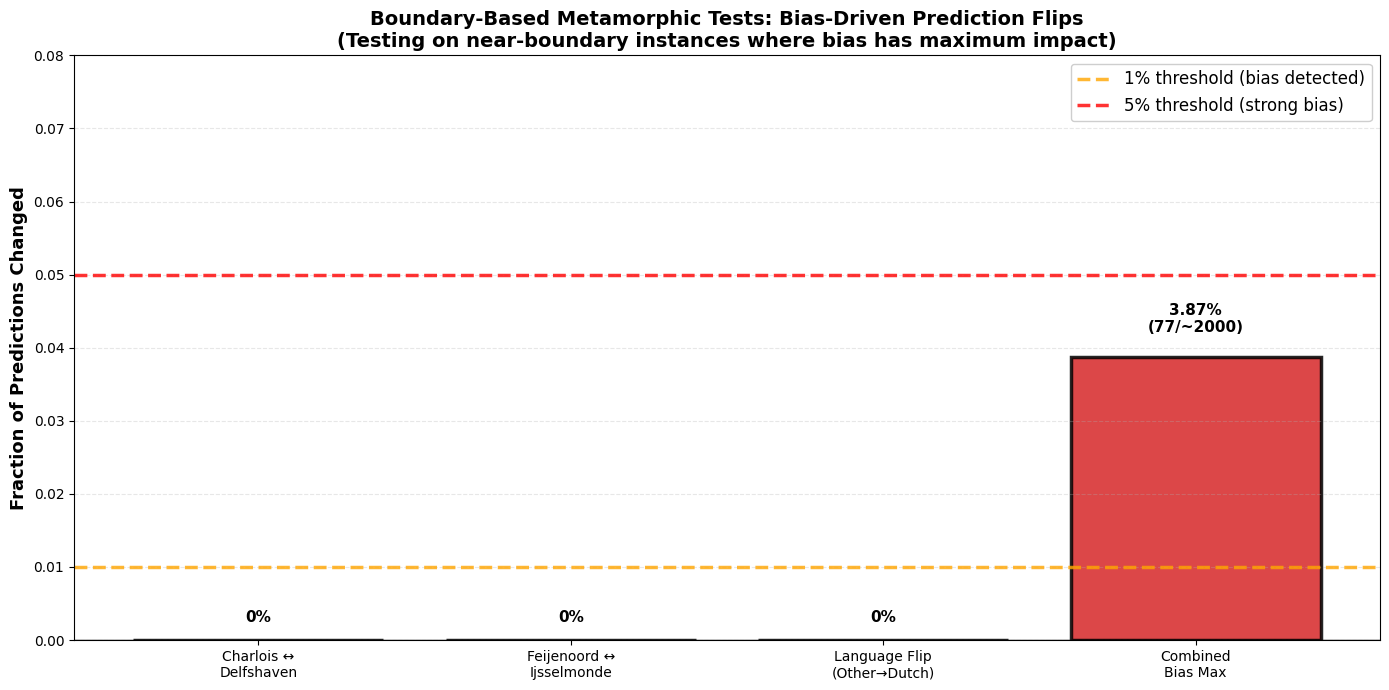


📊 Numerical Summary:
   Average prediction change rate: 0.97%
   Maximum prediction change rate: 3.87%

 MODERATE BIAS: Some boundary predictions are affected by bias features.


In [32]:
# ============================================================
# BOUNDARY METAMORPHIC TEST VISUALIZATION
# ============================================================

def visualize_boundary_metamorphic_results(results):
    """
    Create visualization of boundary metamorphic test results.
    Shows the fraction of predictions changed under various bias perturbations
    when tested on near-boundary instances.
    """
    
    test_names = ['Charlois ↔\nDelfshaven', 'Feijenoord ↔\nIjsselmonde', 
                  'Language Flip\n(Other→Dutch)', 'Combined\nBias Max']
    values = [
        results.get('charlois_delfshaven', 0),
        results.get('feijenoord_ijsselmonde', 0),
        results.get('language_flip', 0),
        results.get('combined_bias', 0)
    ]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    
    colors = ['#d62728' if v > 0.01 else '#ffb3b3' if v > 0 else '#e6e6e6' for v in values]
    bars = ax.bar(test_names, values, color=colors, edgecolor='black', linewidth=2.5, alpha=0.85)
    
    # Add threshold lines
    ax.axhline(y=0.01, color='orange', linestyle='--', linewidth=2.5, label='1% threshold (bias detected)', alpha=0.8)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=2.5, label='5% threshold (strong bias)', alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    
    ax.set_ylabel('Fraction of Predictions Changed', fontweight='bold', fontsize=13)
    ax.set_title('Boundary-Based Metamorphic Tests: Bias-Driven Prediction Flips\n(Testing on near-boundary instances where bias has maximum impact)', 
                 fontweight='bold', fontsize=14)
    ax.set_ylim([0, max(max(values) * 1.3, 0.08)])
    ax.legend(fontsize=12, loc='upper right', framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels
    for bar, val in zip(bars, values):
        height = bar.get_height()
        if val > 0:
            n_changed = int(val * 2000)
            label_text = f'{val*100:.2f}%\n({n_changed}/~2000)'
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.003,
                   label_text, ha='center', va='bottom', fontweight='bold', fontsize=11)
        else:
            ax.text(bar.get_x() + bar.get_width()/2., 0.002,
                   '0%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    plt.tight_layout()
    plt.savefig('boundary_metamorphic_testing.png', dpi=150, bbox_inches='tight')
    print("\n Boundary metamorphic testing visualization saved as 'boundary_metamorphic_testing.png'")
    plt.show()


visualize_boundary_metamorphic_results(boundary_results)

boundary_summary = {
    'charlois_delfshaven': boundary_results.get('charlois_delfshaven', 0),
    'feijenoord_ijsselmonde': boundary_results.get('feijenoord_ijsselmonde', 0),
    'language_flip': boundary_results.get('language_flip', 0),
    'combined_bias': boundary_results.get('combined_bias', 0),
}

avg_change = np.mean(list(boundary_summary.values()))
max_change = max(boundary_summary.values())

print(f"\n📊 Numerical Summary:")
print(f"   Average prediction change rate: {avg_change*100:.2f}%")
print(f"   Maximum prediction change rate: {max_change*100:.2f}%")

if max_change > 0.05:
    print(f"\n  STRONG BIAS EVIDENCE: Metamorphic tests on boundary instances")
    print(f"      reveal significant bias in Model 1's sensitive feature usage.")
elif max_change > 0.01:
    print(f"\n MODERATE BIAS: Some boundary predictions are affected by bias features.")
else:
    print(f"\ LIMITED BIAS EVIDENCE from boundary-based metamorphic tests.")
    print(f"      (However, partition and disparate impact tests DO show discrimination)")



GENERATING BIAS VISUALIZATION
Visualization saved as 'bias_comparison_visualization.png'


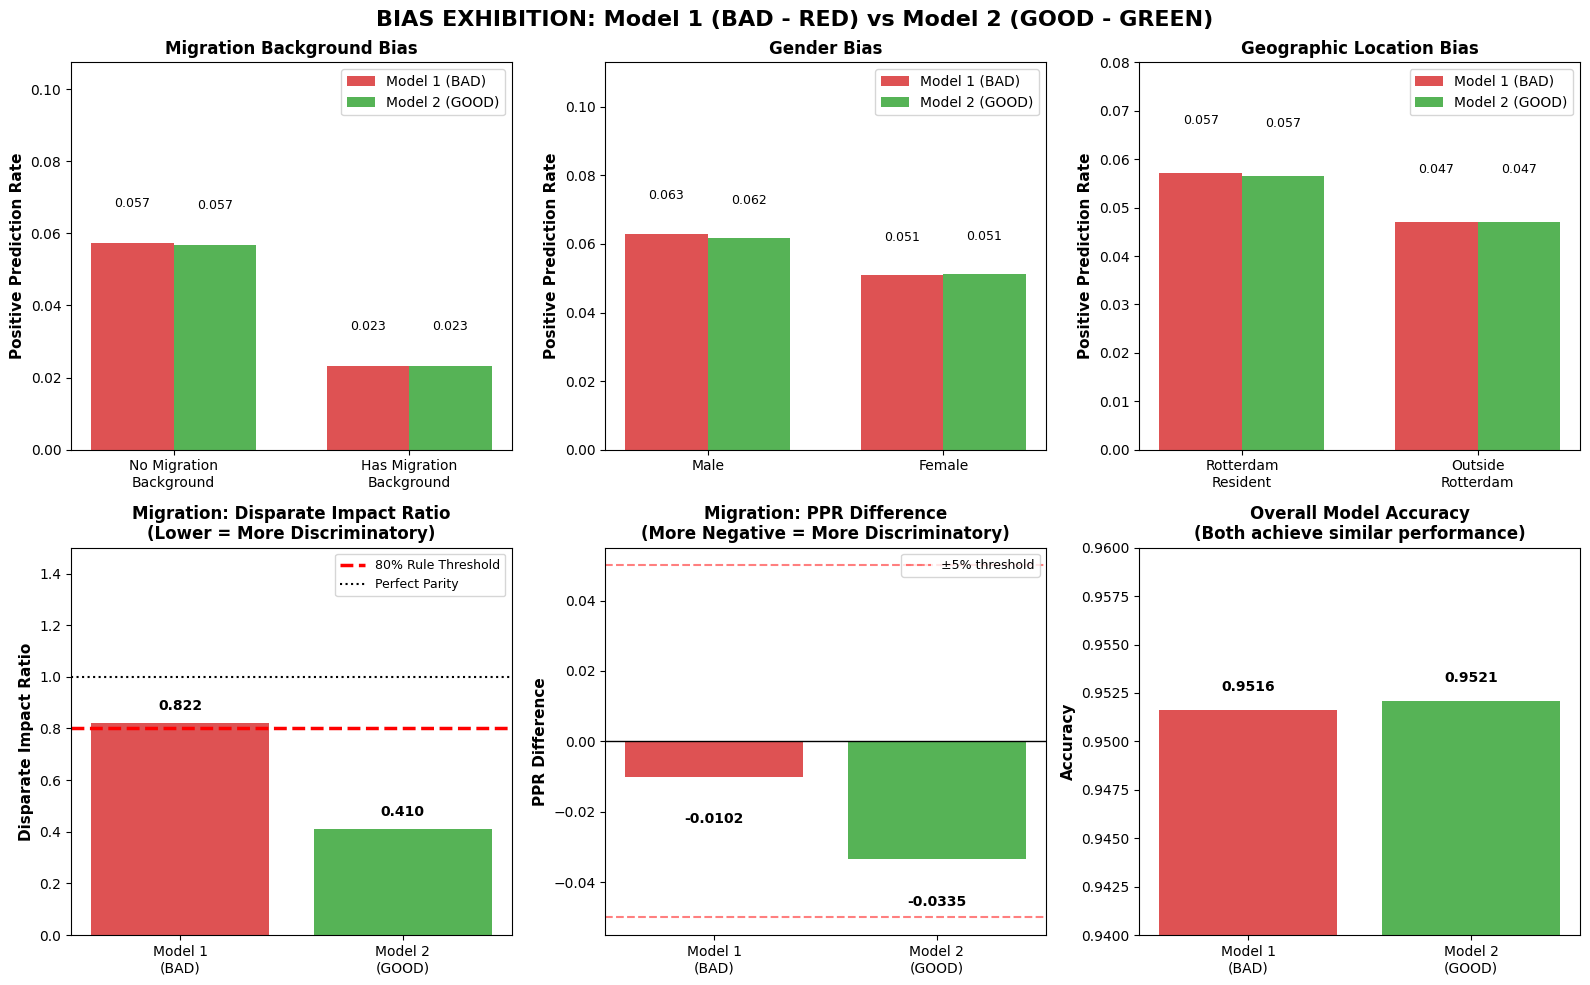

In [33]:
# ============================================================
# VISUALIZATION: BIAS COMPARISON
# ============================================================

import matplotlib.pyplot as plt

def visualize_bias_comparison(X_bad_view, X_good_view, y, preds_bad, preds_good):
    """
    Create side-by-side visualizations comparing bias between models.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('BIAS EXHIBITION: Model 1 (BAD - RED) vs Model 2 (GOOD - GREEN)', 
                 fontsize=16, fontweight='bold')
    
    col = "typering_hist_inburgeringsbehoeftig"
    inburg_mask_0 = X_bad_view[col] == 0
    inburg_mask_1 = X_bad_view[col] == 1
    
    bad_ppr_0 = preds_bad[inburg_mask_0].mean()
    bad_ppr_1 = preds_bad[inburg_mask_1].mean()
    good_ppr_0 = preds_good[inburg_mask_0].mean()
    good_ppr_1 = preds_good[inburg_mask_1].mean()
    
    ax = axes[0, 0]
    groups = ['No Migration\nBackground', 'Has Migration\nBackground']
    x = np.arange(len(groups))
    width = 0.35
    ax.bar(x - width/2, [bad_ppr_0, bad_ppr_1], width, label='Model 1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_0, good_ppr_1], width, label='Model 2 (GOOD)', color='#2ca02c', alpha=0.8)
    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('Migration Background Bias', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=10)
    ax.legend(fontsize=10)
    ax.set_ylim([0, max(bad_ppr_0, bad_ppr_1, good_ppr_0, good_ppr_1) + 0.05])
    
    for i, v in enumerate([bad_ppr_0, bad_ppr_1]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_0, good_ppr_1]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    col = "persoon_geslacht_vrouw"
    gender_mask_0 = X_bad_view[col] == 0
    gender_mask_1 = X_bad_view[col] == 1
    
    bad_ppr_0 = preds_bad[gender_mask_0].mean()
    bad_ppr_1 = preds_bad[gender_mask_1].mean()
    good_ppr_0 = preds_good[gender_mask_0].mean()
    good_ppr_1 = preds_good[gender_mask_1].mean()
    
    ax = axes[0, 1]
    groups = ['Male', 'Female']
    x = np.arange(len(groups))
    ax.bar(x - width/2, [bad_ppr_0, bad_ppr_1], width, label='Model 1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_0, good_ppr_1], width, label='Model 2 (GOOD)', color='#2ca02c', alpha=0.8)
    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('Gender Bias', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=10)
    ax.legend(fontsize=10)
    ax.set_ylim([0, max(bad_ppr_0, bad_ppr_1, good_ppr_0, good_ppr_1) + 0.05])
    
    for i, v in enumerate([bad_ppr_0, bad_ppr_1]):
        ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_0, good_ppr_1]):
        ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    # 3. Geographic Location Impact (Outside Rotterdam)
    col = "adres_recentste_plaats_other"
    loc_mask_0 = X_bad_view[col] == 0
    loc_mask_1 = X_bad_view[col] == 1
    
    bad_ppr_0 = preds_bad[loc_mask_0].mean() if loc_mask_0.sum() > 0 else 0
    bad_ppr_1 = preds_bad[loc_mask_1].mean() if loc_mask_1.sum() > 0 else 0
    good_ppr_0 = preds_good[loc_mask_0].mean() if loc_mask_0.sum() > 0 else 0
    good_ppr_1 = preds_good[loc_mask_1].mean() if loc_mask_1.sum() > 0 else 0
    
    ax = axes[0, 2]
    groups = ['Rotterdam\nResident', 'Outside\nRotterdam']
    x = np.arange(len(groups))
    ax.bar(x - width/2, [bad_ppr_0, bad_ppr_1], width, label='Model 1 (BAD)', color='#d62728', alpha=0.8)
    ax.bar(x + width/2, [good_ppr_0, good_ppr_1], width, label='Model 2 (GOOD)', color='#2ca02c', alpha=0.8)
    ax.set_ylabel('Positive Prediction Rate', fontweight='bold', fontsize=11)
    ax.set_title('Geographic Location Bias', fontweight='bold', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(groups, fontsize=10)
    ax.legend(fontsize=10)
    ax.set_ylim([0, max(bad_ppr_0, bad_ppr_1, good_ppr_0, good_ppr_1, 0.08)])
    
    for i, v in enumerate([bad_ppr_0, bad_ppr_1]):
        if v > 0:
            ax.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    for i, v in enumerate([good_ppr_0, good_ppr_1]):
        if v > 0:
            ax.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)
    
    ax = axes[1, 0]
    inburg_di_bad = bad_ppr_1 / (bad_ppr_0 + 1e-6) if bad_ppr_0 > 0 else 0
    inburg_di_good = preds_good[inburg_mask_1].mean() / (preds_good[inburg_mask_0].mean() + 1e-6)
    
    bars = ax.bar(['Model 1\n(BAD)', 'Model 2\n(GOOD)'], 
                   [inburg_di_bad, inburg_di_good], 
                   color=['#d62728', '#2ca02c'], alpha=0.8)
    ax.axhline(y=0.8, color='red', linestyle='--', linewidth=2.5, label='80% Rule Threshold')
    ax.axhline(y=1.0, color='black', linestyle=':', linewidth=1.5, label='Perfect Parity')
    ax.set_ylabel('Disparate Impact Ratio', fontweight='bold', fontsize=11)
    ax.set_title('Migration: Disparate Impact Ratio\n(Lower = More Discriminatory)', 
                 fontweight='bold', fontsize=12)
    ax.set_ylim([0, 1.5])
    ax.legend(fontsize=9)
    for i, (bar, val) in enumerate(zip(bars, [inburg_di_bad, inburg_di_good])):
        ax.text(i, val + 0.05, f'{val:.3f}', ha='center', fontweight='bold', fontsize=10)
    
    ax = axes[1, 1]
    inburg_diff_bad = bad_ppr_1 - bad_ppr_0
    inburg_diff_good = preds_good[inburg_mask_1].mean() - preds_good[inburg_mask_0].mean()
    
    bars = ax.bar(['Model 1\n(BAD)', 'Model 2\n(GOOD)'], 
                   [inburg_diff_bad, inburg_diff_good], 
                   color=['#d62728', '#2ca02c'], alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.axhline(y=0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='±5% threshold')
    ax.axhline(y=-0.05, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    ax.set_ylabel('PPR Difference', fontweight='bold', fontsize=11)
    ax.set_title('Migration: PPR Difference\n(More Negative = More Discriminatory)', 
                 fontweight='bold', fontsize=12)
    ax.legend(fontsize=9)
    for i, (bar, val) in enumerate(zip(bars, [inburg_diff_bad, inburg_diff_good])):
        label = f'{val:+.4f}'
        y_pos = val + (0.01 if val > 0 else -0.01)
        va = 'bottom' if val > 0 else 'top'
        ax.text(i, y_pos, label, ha='center', fontweight='bold', fontsize=10, va=va)
    
    ax = axes[1, 2]
    bad_acc = accuracy_score(y, preds_bad)
    good_acc = accuracy_score(y, preds_good)
    
    bars = ax.bar(['Model 1\n(BAD)', 'Model 2\n(GOOD)'], 
                   [bad_acc, good_acc], 
                   color=['#d62728', '#2ca02c'], alpha=0.8)
    ax.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
    ax.set_title('Overall Model Accuracy\n(Both achieve similar performance)', 
                 fontweight='bold', fontsize=12)
    ax.set_ylim([0.94, 0.96])
    for i, (bar, val) in enumerate(zip(bars, [bad_acc, good_acc])):
        ax.text(i, val + 0.001, f'{val:.4f}', ha='center', fontweight='bold', fontsize=10)
    
    plt.tight_layout()
    plt.savefig('bias_comparison_visualization.png', dpi=150, bbox_inches='tight')
    print("Visualization saved as 'bias_comparison_visualization.png'")
    plt.show()

print("\n" + "="*90)
print("GENERATING BIAS VISUALIZATION")
print("="*90)
visualize_bias_comparison(X_bad_view, X_good_view, y, preds1, preds2)
